This demo is setup similar to the Dense-demo. Please see there for general comments.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [2]:
mnist_data = mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist_data

In [3]:
print("Training X:", x_train.shape)
print("Training Y:", y_train.shape, y_train[:10])
print("Test X:    ", x_test.shape)
print("Test Y:    ", y_test.shape, y_test[:10])

Training X: (60000, 28, 28)
Training Y: (60000,) [5 0 4 1 9 2 1 3 1 4]
Test X:     (10000, 28, 28)
Test Y:     (10000,) [7 2 1 0 4 1 4 9 5 9]


In [4]:
# Look at data.
def plot_random_training_samples(num, size=5):
  # Create a figure with num subplots (+1 for the colorbar).
  ncols = num + 1
  fig, axes = plt.subplots(ncols=ncols, figsize=(size * ncols, size))

  # Pick random training samples.
  samples = np.random.choice(len(x_train), num)
  # Show each training sample as image using `ax.imshow()` and "gray" colormap.
  for sample, ax in zip(samples, axes.flat):
    ax.set_title("Training Sample #{}".format(sample))
    img = ax.imshow(x_train[sample], cmap="gray")

  # Add a colorbar in last column.
  plt.colorbar(img, cax=axes[-1])

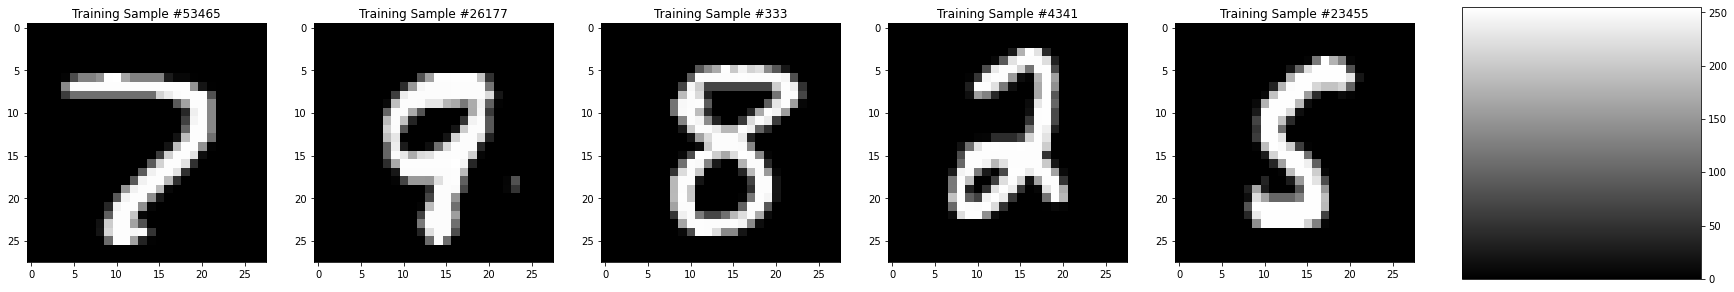

In [5]:
plot_random_training_samples(num=5)

In [6]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential

In [7]:
def create_model() -> Model:
  
  # CNNs expect images with one or more channels. Our images have 1 channel 
  # (greyscale), so the shape is 28x28x1.
  input_shape = (28, 28, 1)

  # Here we show another way to build a model: Create a "Sequential" model
  # and add layers one after onother.
  model = Sequential()
  
  # First, we apply some convolutional layers for feature extraction.
  # Syntax: Conv2D(num_filters, kernel_size, ...)
  model.add(Conv2D(8, (3, 3), activation="relu", input_shape=input_shape))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(16, (3, 3), activation="relu"))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(32, (3, 3), activation="relu"))

  # At the end, add a dense layer and a dense classification layer as output.
  model.add(Flatten())
  model.add(Dense(32, activation="relu",))
  model.add(Dense(10, activation="softmax"))

  # Finally compile the model to prepare for training.
  model.compile(optimizer="adam", 
                loss="categorical_crossentropy", 
                metrics=["accuracy"])
  
  return model

In [8]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                9

In [9]:
# Prepare training data

from tensorflow.keras.utils import to_categorical

def encode_x(x: np.ndarray):
  x = x / 255.0  # Normalize
  return np.expand_dims(x, -1)  # Add dimension of size 1 for channels.


def encode_y(y: np.ndarray):
  return to_categorical(y, num_classes=10)


x_train_enc = encode_x(x_train)
y_train_enc = encode_y(y_train)
print("Shape of X before:", x_train.shape)
print("Shape of X after: ", x_train_enc.shape)
print("Shape of Y before:", y_train.shape)
print("Shape of Y after: ", y_train_enc.shape)

x_test_enc = encode_x(x_test)
y_test_enc = encode_y(y_test)

Shape of X before: (60000, 28, 28)
Shape of X after:  (60000, 28, 28, 1)
Shape of Y before: (60000,)
Shape of Y after:  (60000, 10)


In [10]:
# Train.
model = create_model()
num_epochs = 5
history = model.fit(x=x_train_enc, y=y_train_enc, epochs=num_epochs)

Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2308 - accuracy: 0.9285
Epoch 2/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0726 - accuracy: 0.9778
Epoch 3/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0529 - accuracy: 0.9834
Epoch 4/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0430 - accuracy: 0.9865
Epoch 5/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0371 - accuracy: 0.9883


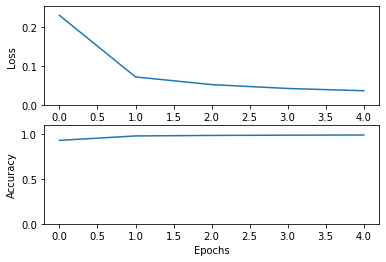

In [11]:
def plot_history(history_dict):
  fig, (ax_loss, ax_acc) = plt.subplots(nrows=2)
  ax_loss.plot(history_dict["loss"], label="Loss")
  ax_loss.set_ylabel("Loss")
  ax_loss.set_xlabel("Epochs")
  ax_loss.set_ylim(0, 1.1 * max(history_dict["loss"]))

  ax_acc.plot(history_dict["accuracy"], label="Accuracy")
  ax_acc.set_ylim(0, 1.1)
  ax_acc.set_ylabel("Accuracy")
  ax_acc.set_xlabel("Epochs")
  
plot_history(history.history)

In [12]:
# Evaluate model on test data.

loss, acc = model.evaluate(x_test_enc, y_test_enc)

print("Test loss:    ", loss)
print("Test accuracy:", acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0333 - accuracy: 0.9898
Test loss:     0.03329797461628914
Test accuracy: 0.989799976348877


In [13]:
# Prediction
print("Single:")
pred = model.predict(x_test_enc[0:1])
pred_class = np.argmax(pred)
print("- Prediction:", pred_class, np.round(pred, 3))

print("Multiple:")
preds = model.predict(x_test_enc[0:3])
preds_class = np.argmax(preds, axis=-1)
for pred, pred_class in zip(preds, preds_class):
  print("- Prediction:", pred_class, np.round(pred, 3))

Single:
- Prediction: 7 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Multiple:
- Prediction: 7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
- Prediction: 2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
- Prediction: 1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
def predict_random_test_samples(model: Model, x_data, num, size=5):
  ncols = num
  nrows = 2
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size * num, size*2))
  
  sample_ids = np.random.choice(len(x_data), num)
  predictions = model.predict(x_data[sample_ids])
  predictions_class = np.argmax(predictions, axis=-1)

  for i in range(ncols):
    ax_img, ax_pred = axes[:, i]
    ax_img.set_title("Prediction {}".format(predictions_class[i]))
    ax_img.imshow(x_data[sample_ids[i]].squeeze(), cmap="gray")
    ax_img.grid(False)
    ax_img.set_xticks([])
    ax_img.set_yticks([])

    ax_pred.bar(range(num), predictions[i])
    ax_pred.set_xticks(range(num))

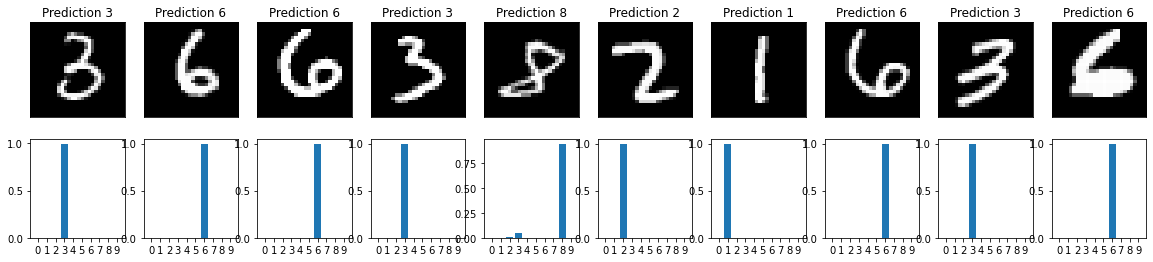

In [15]:
# Training data.
predict_random_test_samples(model, x_train_enc, num=10, size=2)

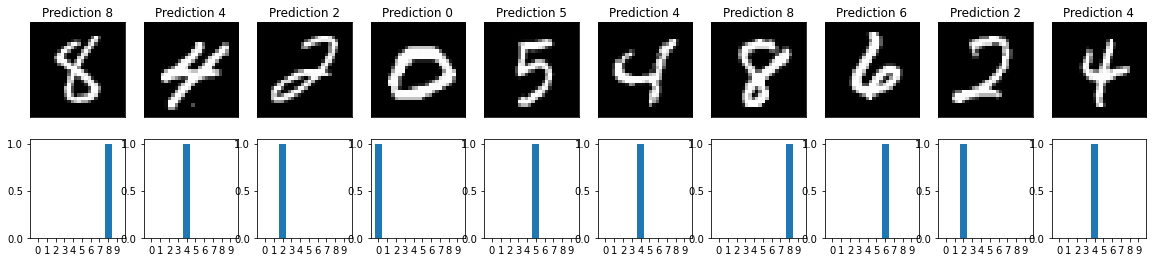

In [16]:
# Test data.
predict_random_test_samples(model, x_test_enc, num=10, size=2)